In [1]:
# 1. IMPORT LIBRARY
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os, shutil
import kagglehub
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
# 2. DOWNLOAD DATASET
path = kagglehub.dataset_download("nurridwan/penyakit-kentang")
print("Dataset path:", path)

100%|██████████| 534M/534M [00:06<00:00, 84.5MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/nurridwan/penyakit-kentang/versions/1


In [6]:
import os

path = "/root/.cache/kagglehub/datasets/nurridwan/penyakit-kentang/versions/1/Penyakit kentang"

# Ambil semua folder kelas
all_classes = [cls for cls in os.listdir(path) if os.path.isdir(os.path.join(path, cls))]
print("Kelas ditemukan:", all_classes)

# Cek jumlah gambar per kelas
for cls in all_classes:
    cls_path = os.path.join(path, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"{cls}: {len(images)} gambar")


Kelas ditemukan: ['Black Scurf', 'Dry Rot', 'Not Potatoes', 'Miscellaneous', 'Pink Rot', 'Healthy Potatoes', 'Common Scab', 'Blackleg']
Black Scurf: 58 gambar
Dry Rot: 60 gambar
Not Potatoes: 925 gambar
Miscellaneous: 74 gambar
Pink Rot: 57 gambar
Healthy Potatoes: 80 gambar
Common Scab: 62 gambar
Blackleg: 60 gambar


In [7]:
# 4. BERSIHKAN FOLDER TRAIN/VAL JIKA PERNAH ADA
import shutil

# 1. Salin dataset dari input ke working_dir
working_dir = "/kaggle/working/batik_dataset"
if os.path.exists(working_dir):
    shutil.rmtree(working_dir)
shutil.copytree(path, working_dir)

# 2. Update path dan definisi train/val
path = working_dir
train_dir = os.path.join(path, 'train')
val_dir = os.path.join(path, 'val')

# 3. Buat folder train dan val
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [8]:
import PIL
base_path = train_dir
for cls in os.listdir(base_path):
    cls_path = os.path.join(base_path, cls)
    count = 0
    for f in os.listdir(cls_path):
        try:
            img = PIL.Image.open(os.path.join(cls_path, f))
            img.verify()
            count += 1
        except:
            pass
    print(f"Kelas '{cls}': {count} gambar valid")

In [9]:
# 5. FUNGSI VALIDASI GAMBAR
def is_valid_image(img_path):
    try:
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            img.load()
        return True
    except Exception as e:
        print(f"❌ Rusak: {img_path} ({e})")
        return False

In [10]:
# 6. FILTER & COPY GAMBAR
for cls in all_classes:
    cls_path = os.path.join(path, cls)
    if not os.path.isdir(cls_path): continue

    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    images = [f for f in images if is_valid_image(os.path.join(cls_path, f))]

    if len(images) < 2:
        print(f"⚠️ Kelas '{cls}' dilewati (hanya {len(images)} gambar valid)")
        continue

    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [11]:
# 7. CEK HASIL PEMISAHAN
print("\nJumlah data per kelas:")
for cls in os.listdir(train_dir):
    print(f"{cls}: train={len(os.listdir(os.path.join(train_dir, cls)))}, val={len(os.listdir(os.path.join(val_dir, cls)))}")


Jumlah data per kelas:
Black Scurf: train=46, val=12
Dry Rot: train=48, val=12
Not Potatoes: train=740, val=185
Miscellaneous: train=59, val=15
Pink Rot: train=45, val=12
Healthy Potatoes: train=64, val=16
Common Scab: train=49, val=13
Blackleg: train=48, val=12


In [12]:
# 8. DATA AUGMENTATION & LOADING
IMG_SIZE = (160, 160)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,  # ⬅️ GANTI dari (150,150)
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,  # ⬅️ GANTI dari (150,150)
    batch_size=32,
    class_mode='categorical'
)

print("Mapping class_indices:", train_generator.class_indices)
print("Jumlah sampel train:", train_generator.samples)
print("Jumlah sampel validasi:", val_generator.samples)


Found 1099 images belonging to 8 classes.
Found 277 images belonging to 8 classes.
Mapping class_indices: {'Black Scurf': 0, 'Blackleg': 1, 'Common Scab': 2, 'Dry Rot': 3, 'Healthy Potatoes': 4, 'Miscellaneous': 5, 'Not Potatoes': 6, 'Pink Rot': 7}
Jumlah sampel train: 1099
Jumlah sampel validasi: 277


In [13]:
# 9. MODEL TRANSFER LEARNING (MobileNetV2)
num_classes = len(train_generator.class_indices)
print("Jumlah kelas:", num_classes)

base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # freeze base model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Jumlah kelas: 8
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
# 10. TRAINING
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 868ms/step - accuracy: 0.9891 - loss: 0.0361 - val_accuracy: 0.8989 - val_loss: 0.4417
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 847ms/step - accuracy: 0.9914 - loss: 0.0305 - val_accuracy: 0.8989 - val_loss: 0.4265
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 825ms/step - accuracy: 0.9858 - loss: 0.0319 - val_accuracy: 0.8845 - val_loss: 0.4431
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 875ms/step - accuracy: 0.9905 - loss: 0.0312 - val_accuracy: 0.8917 - val_loss: 0.4417
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 835ms/step - accuracy: 0.9900 - loss: 0.0285 - val_accuracy: 0.8917 - val_loss: 0.4384
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 884ms/step - accuracy: 0.9949 - loss: 0.0263 - val_accuracy: 0.8845 - val_loss: 0.4259
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 842ms/step - accuracy: 0.9924 - loss: 0.0274 - val_accuracy: 0.8917 - val_loss: 0.4321
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 863ms/step - accuracy: 0.9964 - loss: 0.0265 - val_accu

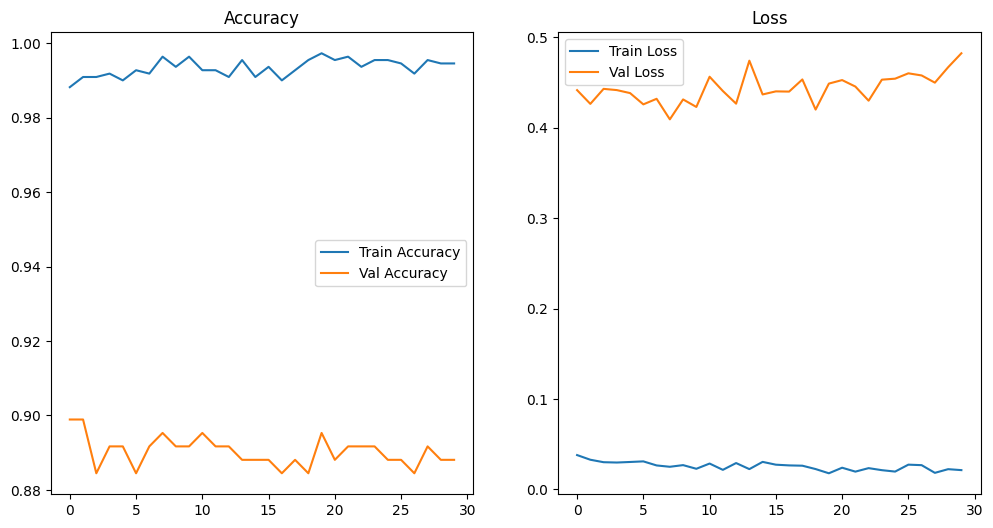

In [21]:
# 11. VISUALISASI HASIL
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [27]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
    # Load & preprocess image
    img = image.load_img(fn, target_size=(160, 160))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    # Predict
    prediction = model.predict(x)[0]  # ambil array dari hasil prediksi
    class_names = list(train_generator.class_indices.keys())

    # Ambil 3 prediksi teratas
    top_3_indices = prediction.argsort()[-3:][::-1]  # index 3 nilai tertinggi
    print(f"\nGambar '{fn}' diklasifikasikan sebagai:")

    for i in top_3_indices:
        label = class_names[i]
        confidence = prediction[i] * 100
        print(f"  • {label}: {confidence:.2f}%")


Saving dayak.jpg to dayak.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Gambar 'dayak.jpg' diklasifikasikan sebagai:
  • Not Potatoes: 100.00%
  • Black Scurf: 0.00%
  • Common Scab: 0.00%


In [28]:
# Simpan model
model.save('model_kentang.h5')

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model_kentang.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpvv05rxr1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  137538127160400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137538127164048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137538127165776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137538127167312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137538127166352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137538127163664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137538114666576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137538114667728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137538127166544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137538114667536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1375381146

In [29]:
from google.colab import files
files.download('model_kentang.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>